# `evosax`: JAX-Based Evolution Strategies
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: February 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/getting_started.ipynb)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## The `evosax` Ask-Eval-Tell API

In [2]:
import jax
import jax.numpy as jnp
from evosax import CMA_ES
from evosax.problems import ClassicFitness

rng = jax.random.PRNGKey(0)
# Instantiate the evolution strategy instance
strategy = CMA_ES(num_dims=2, popsize=10)

# Get default parameters (e.g. lrate, etc.)
es_params = strategy.default_params

# Initialize the strategy
state = strategy.initialize(rng, es_params)

es_params

{'mu_eff': DeviceArray(3.1672993, dtype=float32),
 'c_1': DeviceArray(0.14227483, dtype=float32),
 'c_mu': DeviceArray(0.1547454, dtype=float32),
 'c_m': 1,
 'c_sigma': DeviceArray(0.5082273, dtype=float32),
 'd_sigma': DeviceArray(1.5082273, dtype=float32),
 'c_c': DeviceArray(0.60908335, dtype=float32),
 'chi_n': DeviceArray(1.2542727, dtype=float32),
 'weights': DeviceArray([ 0.45627266,  0.27075312,  0.16223113,  0.08523356,
               0.0255096 , -0.09313656, -0.25813884, -0.4010702 ,
              -0.5271447 , -0.63992214], dtype=float32),
 'sigma_init': 1,
 'weights_truncated': DeviceArray([0.45627266, 0.27075312, 0.16223113, 0.08523356, 0.0255096 ,
              0.        , 0.        , 0.        , 0.        , 0.        ],            dtype=float32),
 'clip_min': -3.4028235e+38,
 'clip_max': 3.4028235e+38,
 'init_min': -2,
 'init_max': 2}

In [3]:
evaluator = ClassicFitness("rosenbrock", num_dims=2)

Given our initialized strategy we are now ready to `ask` for a set of candidate parameters. Afterwards, we evaluate these on the 2D Rosenbrock problem and `tell` them to our strategy. The strategy will update its `state` and we can iterate.

In [4]:
# Ask for a set of candidate solutions to evaluate
x, state = strategy.ask(rng, state, es_params)
fitness = evaluator.rollout(rng, x)
state = strategy.tell(x, fitness, state, es_params)

### Running the ES Loop with Logging

In [5]:
from evosax.utils import ESLog
es_logging = ESLog(num_dims=2, num_generations=50, top_k=3)

(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Rosenbrock CMA-ES'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

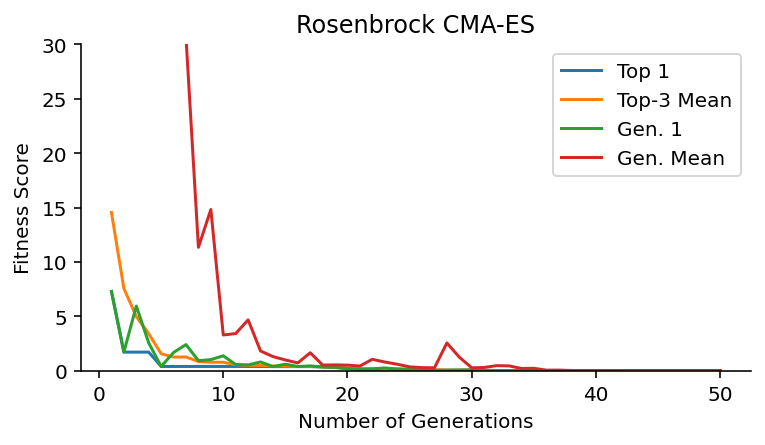

In [6]:
log = es_logging.initialize()
state = strategy.initialize(rng, es_params)
for i in range(50):
    rng, rng_ask = jax.random.split(rng)
    x, state = strategy.ask(rng_ask, state, es_params)
    fitness = evaluator.rollout(rng, x)
    state = strategy.tell(x, fitness, state, es_params)
    log = es_logging.update(log, x, fitness)
    
es_logging.plot(log, "Rosenbrock CMA-ES", ylims=(0, 30))

## Neuroevolution with Automatic PyTree Parameter Reshaping

In [7]:
from flax import linen as nn


class MLP(nn.Module):
    """Simple ReLU MLP."""

    num_hidden_units: int
    num_hidden_layers: int
    num_output_units: int

    @nn.compact
    def __call__(self, x, rng):
        for l in range(self.num_hidden_layers):
            x = nn.Dense(features=self.num_hidden_units)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_output_units)(x)
        return jax.random.categorical(rng, x)
    

network = MLP(64, 2, 2)
policy_params = network.init(rng, jnp.zeros(4,), rng)["params"]

In [8]:
from evosax.utils import ParameterReshaper

param_reshaper = ParameterReshaper(policy_params)

print(param_reshaper.total_params)

# Dictinory to vectorize rollouts with
param_reshaper.vmap_dict

4610


{'Dense_0': {'bias': 0, 'kernel': 0},
 'Dense_1': {'bias': 0, 'kernel': 0},
 'Dense_2': {'bias': 0, 'kernel': 0}}

In [9]:
from evosax import Differential_ES
strategy = Differential_ES(popsize=100, num_dims=param_reshaper.total_params)
state = strategy.initialize(rng, strategy.default_params)

x, state = strategy.ask(rng, state, strategy.default_params)
x.shape

(100, 4610)

In [10]:
net_params = param_reshaper.reshape(x)
net_params['Dense_0']['kernel'].shape

(100, 4, 64)

## ARS on CartPole Task with Fitness Reshaping

In [11]:
from evosax import FitnessShaper
from evosax.problems import GymFitness

evaluator = GymFitness()
evaluator.set_apply_fn(network.apply)

rollout = jax.jit(jax.vmap(evaluator.rollout, in_axes=(None, param_reshaper.vmap_dict)))

fit_shaper = FitnessShaper(maximize=True)

In [12]:
from evosax import Augmented_RS

strategy = Augmented_RS(popsize=100, num_dims=param_reshaper.total_params,
                        elite_ratio=0.1, opt_name="sgd")

es_params = {
        "lrate_init": 0.01,  # Adam learning rate outer step
        "lrate_decay": 0.999,
        "lrate_limit": 0.001,
        "momentum": 0.0,
        "sigma_init": 0.02,
        "sigma_decay": 0.999,
        "sigma_limit": 0.01,
        "init_min": -0.1,
        "init_max": 0.1,
        "clip_min": -10,
        "clip_max": 10
}

In [13]:
state = strategy.initialize(rng, es_params)
x, state = strategy.ask(rng, state, es_params)
net_params = param_reshaper.reshape(x)

In [14]:
# Update the strategy with the negative mean returns (Note: ES minimizes!)
num_rollouts = 20
fitness = rollout(jax.random.split(rng, num_rollouts), net_params).mean(axis=1)
fit_re = fit_shaper.apply(x, fitness)
state = strategy.tell(x, fit_re, state, es_params)
-state["best_fitness"], state["best_member"].shape

(DeviceArray(23.35, dtype=float32), (4610,))

Return:  0 22.85
Return:  20 29.6
Return:  40 34.75
Return:  60 34.75
Return:  80 35.850002
Return:  100 50.05
Return:  120 53.5
Return:  140 81.85
Return:  160 110.1
Return:  180 167.35
Return:  200 198.05
Return:  220 200.0
Return:  240 200.0
Return:  260 200.0
Return:  280 200.0
Return:  300 200.0
Return:  320 200.0
Return:  340 200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Pendulum Differential Evolution'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

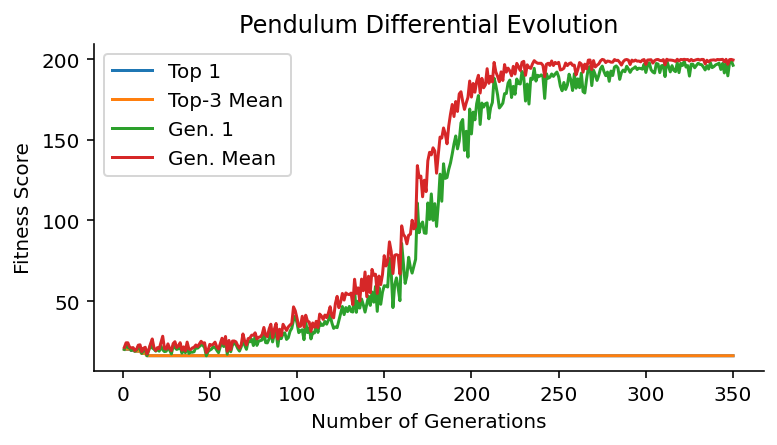

In [16]:
num_generations = 350
print_every_k_gens = 20
state = strategy.initialize(rng, es_params)
es_logging = ESLog(param_reshaper.total_params, num_generations, top_k=3)
log = es_logging.initialize()

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state, es_params)
    reshaped_params = param_reshaper.reshape(x)
    batch_rng = jax.random.split(rng_eval, num_rollouts)
    fitness = rollout(batch_rng, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Return: ", gen, -state["best_fitness"])
        
es_logging.plot(log, "Pendulum Differential Evolution")